In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from pycaret.classification import *
import shap

In [2]:
raw_data_joined = pd.read_csv('./output/raw_data_joined.csv', index_col=0)

In [3]:
comorb_lst = [i for i in raw_data_joined.columns if "DISEASE" in i]
comorb_lst.extend(["HTN", "IMMUNOCOMPROMISED", "OTHER"])

demo_lst = [i for i in raw_data_joined.columns if "AGE_" in i]
demo_lst.append("GENDER")


vitalSigns_lst = raw_data_joined.iloc[:,193:-2].columns.tolist()

lab_lst = raw_data_joined.iloc[:,13:193].columns.tolist()

As warned by the authors ("Beware NOT to use the data when the target variable is present, as it is unknown the order of the event (maybe the target event happened before the results were obtained)") which means that the inpatient's lab results could have been obtained after the inpatient's entry in the ICU thus rendering that data pointless

We will focus on creating a model that works within the 0-2 window since it's more clinically relevant. Therefore, all the data from patients admitted between the 0-2 window should be dropped

In [4]:
# ICU per window
pd.crosstab(raw_data_joined.WINDOW, raw_data_joined.ICU)

ICU,0,1
WINDOW,,
0-2,353,32
2-4,326,59
4-6,286,99
6-12,255,130
ABOVE_12,190,195


In [5]:
# Dropping the patients which were admitted to ICU in the first window
train_data = raw_data_joined.loc[~((raw_data_joined['WINDOW'] == '0-2') & (raw_data_joined['ICU'] == 1))]
train_data

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
3,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0
4,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,384,0,50,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1921,384,0,50,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
1922,384,0,50,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
1923,384,0,50,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0


In [6]:
icu_above_2 = train_data.groupby('PATIENT_VISIT_IDENTIFIER')\
    .agg({'ICU': max})\
    .reset_index()\
    .rename(columns={'ICU': 'ICU_NEW'})
    
# Merge back to original df
training_data = train_data.merge(icu_above_2, on=['PATIENT_VISIT_IDENTIFIER'], how='left')

It is important to notice the addition of a new column at the end of the dataset that tells us if the patient went into the ICU after the window we are studying to obtain the groundtruth value

In [7]:
training_data.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_NEW
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
1,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0,1
2,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0,1
3,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0,1
4,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1,1


In [8]:
# Valid cases per window
pd.crosstab(training_data.WINDOW, training_data.ICU)

ICU,0,1
WINDOW,,
0-2,353,0
2-4,326,59
4-6,286,99
6-12,255,130
ABOVE_12,190,195


In [9]:
# keep only features from 0-2 hour window
mask_02 = training_data.WINDOW == '0-2'
training_data = training_data.loc[mask_02]

# valid cases for training
pd.crosstab(training_data.WINDOW, training_data.ICU_NEW)

ICU_NEW,0,1
WINDOW,,
0-2,190,163


We are left with 353 rows total but is as expected taking into account the demand for clinically relevant results

In [10]:
training_data

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_NEW
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
9,2,0,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,0,1
14,3,0,40,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0
19,4,0,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0,0
24,5,0,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,380,0,40,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
1873,381,1,90,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.612627,-1.000000,0-2,0,0
1878,382,0,50,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
1883,383,0,40,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0


In [11]:
data_pycaret = training_data.iloc[0:300,:]
data_pycaret.shape

(300, 232)

In [12]:
unseen_data_pycaret = training_data.iloc[300:353,:]
unseen_data_pycaret.shape

(53, 232)

In [13]:
SEED = 440
experiment = setup(
    data_pycaret, 
    target='ICU_NEW',
    ignore_features=['PATIENT_VISIT_IDENTIFIER', 'ICU', 'WINDOW'],
    #+lab_columns_to_ignore,
    #fix_imbalance=True, # fixing train-test split imbalances
    #feature_selection=True, feature_selection_threshold=0.95, # conservative important feature selection
    #remove_perfect_collinearity=True, # in case we missed any perfectly collinear features
    session_id=SEED, # seed for reproductibility
    #silent=True # for kaggle compatibility
    )


 
Setup Succesfully Completed!


,Description,Value
0,session_id,440
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(300, 232)"
4,Missing Values,False
5,Numeric Features,217
6,Categorical Features,14
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [14]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Logistic Regression,0.722900,0.767400,0.680000,0.730000,0.700600,0.443600
1,Extra Trees Classifier,0.707900,0.760900,0.610000,0.743800,0.664200,0.410900
2,Ada Boost Classifier,0.689000,0.755800,0.690000,0.706100,0.681400,0.379800
3,Ridge Classifier,0.684500,0.000000,0.620000,0.697500,0.650200,0.365600
4,CatBoost Classifier,0.684000,0.765000,0.620000,0.713000,0.651400,0.365400
5,SVM - Linear Kernel,0.670000,0.000000,0.740000,0.682300,0.673600,0.344200
6,Random Forest Classifier,0.650700,0.703500,0.510000,0.698600,0.583900,0.293300
7,Extreme Gradient Boosting,0.650700,0.675100,0.580000,0.677400,0.607900,0.297300
8,Gradient Boosting Classifier,0.636200,0.707500,0.600000,0.649400,0.613300,0.271400
9,Light Gradient Boosting Machine,0.632100,0.693600,0.610000,0.618900,0.607900,0.262600


PyCaret's recommended experiment workflow is to use compare_models() right after setup to evaluate top performing models and finalize a few candidates for continued experimentation. As such, the function that actually allows to you create a model is unimaginatively called create_model(). This function creates a model and scores it using stratified cross-validation. Similar to compare_models(), the output prints a score grid that shows Accuracy, Recall, Precision, F1 and Kappa by fold.

For the remaining part of this project, we will work with the top 5 models as our candidate models. The selections are for illustration purposes only and do not necessarily mean they are the top performing or ideal for this type of data.

- Extra Trees Classifier('et')
- CatBoost Classifier('catboost')
- Random Forest Classifier('rf')
- Logistic Regression('lr')
- Extreme Gradient Boosting('xgboost')

##### Random Forest Classifier

In [15]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.6190,0.7455,0.5000,0.6250,0.5556,0.2294
1,0.6667,0.7591,0.5000,0.7143,0.5882,0.3226
2,0.7619,0.8182,0.5000,1.0000,0.6667,0.5116
3,0.7619,0.7455,0.6000,0.8571,0.7059,0.5161
4,0.7143,0.7364,0.5000,0.8333,0.6250,0.4167
5,0.4286,0.4955,0.3000,0.3750,0.3333,-0.1560
6,0.7143,0.8000,0.7000,0.7000,0.7000,0.4273
7,0.5238,0.4727,0.4000,0.5000,0.4444,0.0367
8,0.6667,0.6818,0.6000,0.6667,0.6316,0.3288
9,0.6500,0.7800,0.5000,0.7143,0.5882,0.3000


In [16]:
tuned_rf = tune_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7619,0.7636,0.6000,0.8571,0.7059,0.5161
1,0.7619,0.7273,0.8000,0.7273,0.7619,0.5249
2,0.7143,0.7727,0.6000,0.7500,0.6667,0.4220
3,0.8095,0.8727,0.6000,1.0000,0.7500,0.6111
4,0.7143,0.7818,0.6000,0.7500,0.6667,0.4220
5,0.5714,0.6909,0.7000,0.5385,0.6087,0.1525
6,0.8095,0.8000,0.8000,0.8000,0.8000,0.6182
7,0.5714,0.6545,0.5000,0.5556,0.5263,0.1370
8,0.7143,0.7727,0.7000,0.7000,0.7000,0.4273
9,0.6500,0.8000,0.7000,0.6364,0.6667,0.3000


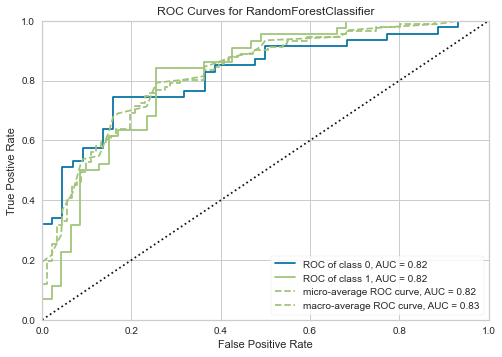

In [17]:
plot_model(tuned_rf, plot = 'auc')

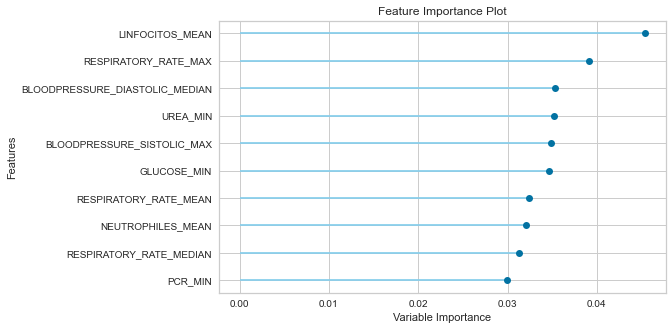

In [18]:
plot_model(tuned_rf, plot='feature')

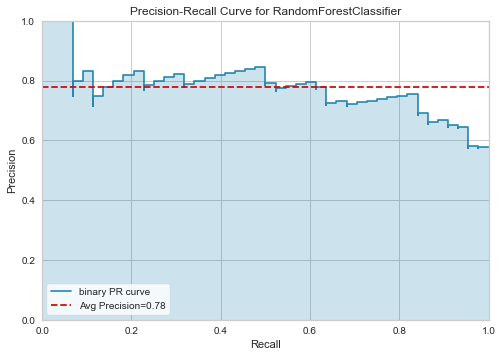

In [19]:
plot_model(tuned_rf, plot = 'pr')

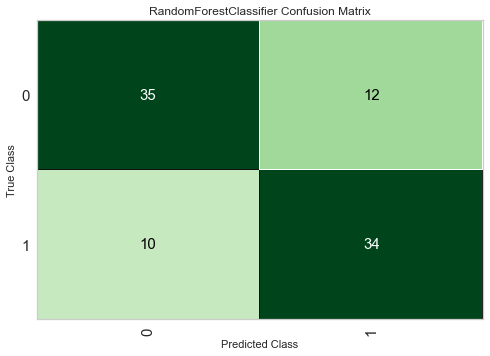

In [20]:
plot_model(tuned_rf, plot = 'confusion_matrix')

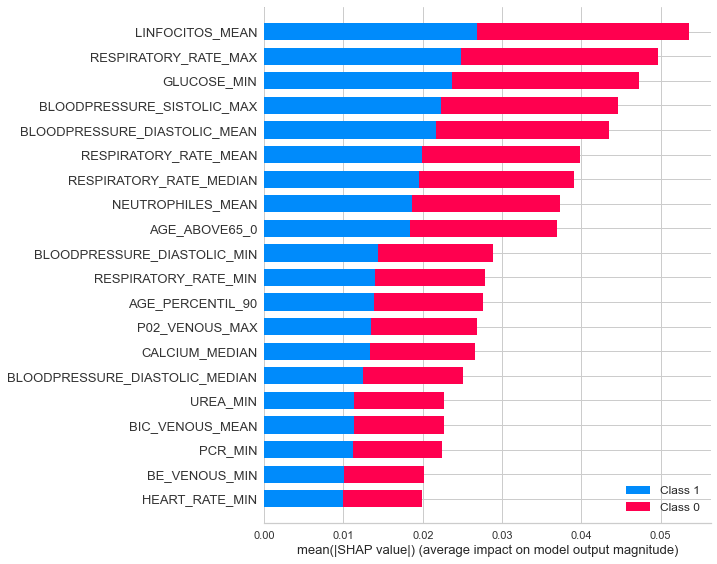

In [21]:
interpret_model(tuned_rf)

In [22]:
interpret_model(tuned_rf, plot='reason', observation = 10)

In [23]:
predict_model(tuned_rf);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Random Forest Classifier,0.7582,0.8216,0.7727,0.7391,0.7556,0.5167


In [24]:
final_rf = finalize_model(tuned_rf)

In [25]:
unseen_predictions_rf = predict_model(final_rf, data=unseen_data_pycaret)

In [26]:
unseen_predictions_rf

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_NEW,Label,Score
0,327,1,80,1,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1,0,0.4414
1,328,0,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-0.884550,-1.000000,-1.000000,0-2,0,0,0,0.1539
2,330,1,90,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0,0,0.4572
3,331,1,70,0,1.0,0.0,1.0,0.0,0.0,1.0,...,-0.757291,-0.827501,-0.878136,-0.639873,-0.979601,0-2,0,0,0,0.4922
4,332,1,80,0,0.0,0.0,1.0,0.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0,1,0.8016
5,333,1,90,0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0,1,0.8172
6,334,0,40,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0,0,0.3361
7,335,1,80,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0,0,0.4914
8,336,0,10,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0,0,0.1889
9,337,0,20,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.869128,-0.946657,-0.884550,-0.906315,-0.959202,0-2,0,1,0,0.4092


In [27]:
unseen_predictions_rf.ICU_NEW.value_counts()

0    34
1    19
Name: ICU_NEW, dtype: int64

In [28]:
unseen_predictions_rf.Label.value_counts()

0    35
1    18
Name: Label, dtype: int64

## PyCaret with the dataframe Standarized and Normalized

In [29]:
raw_data_joined_normalized = pd.read_csv('./output/raw_data_joined_normalized.csv', index_col=0)

In [30]:
raw_data_joined_normalized

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60,0,-0.041853,-0.020429,-0.039560,-0.017064,0.314148,0.542968,...,-0.070432,-0.039602,-0.066468,-0.067127,-0.066671,-0.061639,-0.070358,-0.039569,0-2,0
1,0,1,60,0,-0.037514,-0.018311,-0.035459,-0.015295,0.281580,0.486677,...,-0.063130,-0.035497,-0.059577,-0.060168,-0.059759,-0.055248,-0.063064,-0.035467,2-4,0
2,0,1,60,0,-0.037514,-0.018311,-0.035459,-0.015295,0.281580,0.486677,...,-0.063130,-0.035497,-0.059577,-0.060168,-0.059759,-0.055248,-0.063064,-0.035467,4-6,0
3,0,1,60,0,-0.041088,-0.020055,-0.038837,-0.016752,0.308409,0.533048,...,-0.069145,-0.038879,-0.065254,-0.065901,-0.065453,-0.060512,-0.069072,-0.038846,6-12,0
4,0,1,60,0,-0.018762,-0.009158,-0.017734,-0.007649,0.140825,0.243399,...,0.111539,0.022440,0.086509,0.178283,0.146013,0.129847,0.111372,0.023194,ABOVE_12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,384,0,50,1,-0.036946,-0.018033,-0.034922,-0.015063,-0.040631,-0.023508,...,-0.062174,-0.034959,-0.058675,-0.059257,-0.058854,-0.054412,-0.062109,-0.034930,0-2,0
1921,384,0,50,1,-0.038498,-0.018791,-0.036389,-0.015696,-0.042339,-0.024496,...,-0.064787,-0.036428,-0.061141,-0.061747,-0.061327,-0.056698,-0.064719,-0.036397,2-4,0
1922,384,0,50,1,-0.039982,-0.019516,-0.037792,-0.016302,-0.043971,-0.025440,...,-0.067284,-0.037833,-0.063498,-0.064127,-0.063692,-0.058884,-0.067214,-0.037801,4-6,0
1923,384,0,50,1,-0.035692,-0.017422,-0.033737,-0.014552,-0.039253,-0.022711,...,-0.060065,-0.033773,-0.056685,-0.057247,-0.056858,-0.052566,-0.060002,-0.033745,6-12,0


In [31]:
train_data_normalized = raw_data_joined_normalized.loc[~((raw_data_joined_normalized['WINDOW'] == '0-2') & (raw_data_joined_normalized['ICU'] == 1))]

icu_above_2_normalized = train_data_normalized.groupby('PATIENT_VISIT_IDENTIFIER')\
    .agg({'ICU': max})\
    .reset_index()\
    .rename(columns={'ICU': 'ICU_NEW'})

training_data_normalized = train_data_normalized.merge(icu_above_2_normalized, on=['PATIENT_VISIT_IDENTIFIER'], how='left')

mask_02 = training_data_normalized.WINDOW == '0-2'

training_data_normalized = training_data_normalized.loc[mask_02]

In [32]:
training_data_normalized

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_NEW
0,0,1,60,0,-0.041853,-0.020429,-0.039560,-0.017064,0.314148,0.542968,...,-0.039602,-0.066468,-0.067127,-0.066671,-0.061639,-0.070358,-0.039569,0-2,0,1
9,2,0,10,0,-0.030023,-0.014654,-0.028378,-0.012241,-0.033018,-0.019103,...,-0.014116,0.100127,0.105517,0.044716,0.011784,-0.050471,-0.014711,0-2,0,1
14,3,0,40,1,-0.021905,-0.010692,-0.020705,-0.008931,-0.024090,-0.013938,...,-0.020727,-0.034788,-0.035133,-0.034895,-0.032261,-0.036824,-0.020710,0-2,0,0
19,4,0,10,0,-0.039387,-0.019225,-0.037230,-0.016059,-0.043316,-0.025062,...,-0.027894,-0.062553,-0.027018,-0.042016,-0.019113,-0.047816,-0.028131,0-2,0,0
24,5,0,10,0,-0.038380,-0.018733,-0.036277,-0.015648,-0.042209,-0.024421,...,-0.027181,-0.006690,0.024916,-0.054818,-0.056524,-0.055218,-0.027320,0-2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,380,0,40,1,-0.009744,-0.004756,-0.009211,-0.003973,-0.010716,-0.006200,...,-0.009220,-0.015476,-0.015629,-0.015523,-0.014351,-0.016381,-0.009213,0-2,0,1
1873,381,1,90,0,-0.047333,-0.023104,-0.044740,-0.019299,-0.052055,-0.030118,...,-0.044788,-0.075172,-0.075918,-0.075402,-0.069710,0.104755,-0.044751,0-2,0,0
1878,382,0,50,0,-0.040780,-0.019905,-0.038546,-0.016627,-0.044848,-0.025948,...,-0.038588,-0.064765,-0.065407,-0.064963,-0.060059,-0.068555,-0.038555,0-2,0,1
1883,383,0,40,1,-0.059346,-0.028967,-0.056095,-0.024197,-0.065266,-0.037762,...,-0.056155,-0.094251,-0.095185,-0.094538,-0.087402,-0.099766,-0.056108,0-2,0,0


In [33]:
data_pycaret_normalized = training_data_normalized.iloc[0:300,:]
data_pycaret_normalized.shape

(300, 232)

In [34]:
unseen_data_pycaret_normalized = training_data_normalized.iloc[300:353,:]
unseen_data_pycaret_normalized.shape

(53, 232)

In [35]:
SEED = 440
experiment = setup(
    data_pycaret_normalized, 
    target='ICU_NEW',
    ignore_features=['PATIENT_VISIT_IDENTIFIER', 'ICU', 'WINDOW'],
    #+lab_columns_to_ignore,
    #fix_imbalance=True, # fixing train-test split imbalances
    #feature_selection=True, feature_selection_threshold=0.95, # conservative important feature selection
    #remove_perfect_collinearity=True, # in case we missed any perfectly collinear features
    session_id=SEED, # seed for reproductibility
    #silent=True # for kaggle compatibility
    )

 
Setup Succesfully Completed!


,Description,Value
0,session_id,440
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(300, 232)"
4,Missing Values,False
5,Numeric Features,226
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [36]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Logistic Regression,0.718100,0.778200,0.710000,0.711000,0.707100,0.435500
1,Ridge Classifier,0.699000,0.000000,0.700000,0.686300,0.689800,0.398000
2,Extra Trees Classifier,0.693600,0.776700,0.670000,0.704500,0.679700,0.386200
3,Extreme Gradient Boosting,0.688800,0.746300,0.640000,0.695800,0.660000,0.374600
4,Light Gradient Boosting Machine,0.688600,0.759200,0.650000,0.686600,0.665000,0.374500
5,CatBoost Classifier,0.684300,0.767500,0.630000,0.700100,0.657100,0.366100
6,Ada Boost Classifier,0.674800,0.707700,0.650000,0.681200,0.655800,0.347800
7,Gradient Boosting Classifier,0.674800,0.734500,0.650000,0.670500,0.657800,0.348500
8,Naive Bayes,0.656000,0.729000,0.410000,0.767300,0.521100,0.296300
9,SVM - Linear Kernel,0.646400,0.000000,0.630000,0.654600,0.629000,0.293100


In [37]:
catboost_n = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.6667,0.7818,0.60,0.6667,0.6316,0.3288
1,0.6667,0.7818,0.50,0.7143,0.5882,0.3226
2,0.7143,0.6545,0.50,0.8333,0.6250,0.4167
3,0.9524,0.9091,0.90,1.0000,0.9474,0.9041
4,0.6190,0.7273,0.60,0.6000,0.6000,0.2364
5,0.6190,0.7182,0.60,0.6000,0.6000,0.2364
6,0.7143,0.8636,0.70,0.7000,0.7000,0.4273
7,0.5238,0.6455,0.60,0.5000,0.5455,0.0541
8,0.6667,0.7727,0.70,0.6364,0.6667,0.3348
9,0.7000,0.8200,0.60,0.7500,0.6667,0.4000


In [40]:
tuned_rf_n = tune_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.6667,0.7818,0.5000,0.7143,0.5882,0.3226
1,0.7619,0.8318,0.7000,0.7778,0.7368,0.5205
2,0.7143,0.6409,0.5000,0.8333,0.6250,0.4167
3,0.9048,0.9000,0.8000,1.0000,0.8889,0.8073
4,0.6190,0.7273,0.6000,0.6000,0.6000,0.2364
5,0.6190,0.6773,0.7000,0.5833,0.6364,0.2432
6,0.6667,0.8500,0.7000,0.6364,0.6667,0.3348
7,0.5238,0.5909,0.6000,0.5000,0.5455,0.0541
8,0.7143,0.7727,0.7000,0.7000,0.7000,0.4273
9,0.6500,0.7400,0.6000,0.6667,0.6316,0.3000


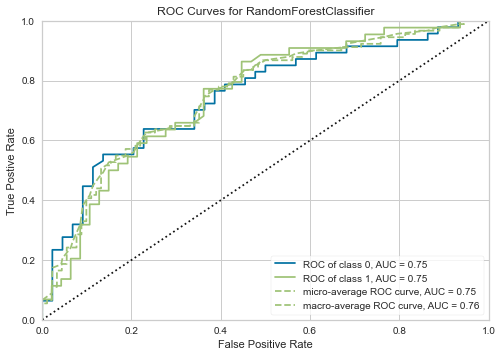

In [41]:
plot_model(tuned_rf_n, plot = 'auc')

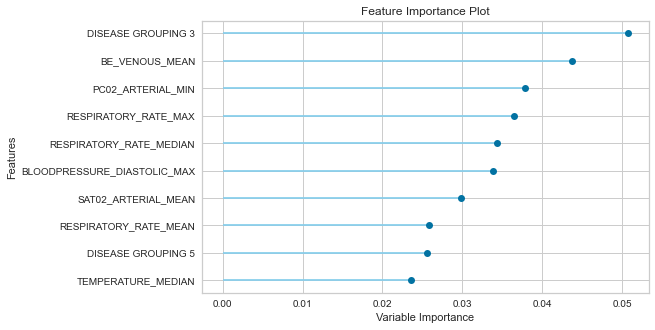

In [42]:
plot_model(tuned_rf_n, plot='feature')

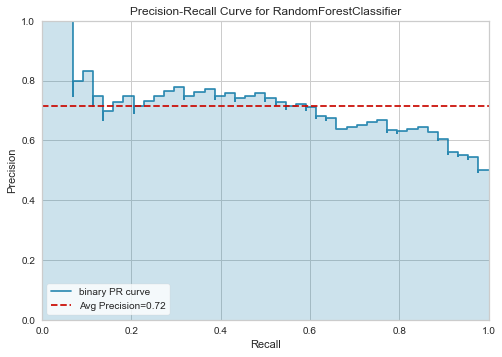

In [43]:
plot_model(tuned_rf_n, plot = 'pr')

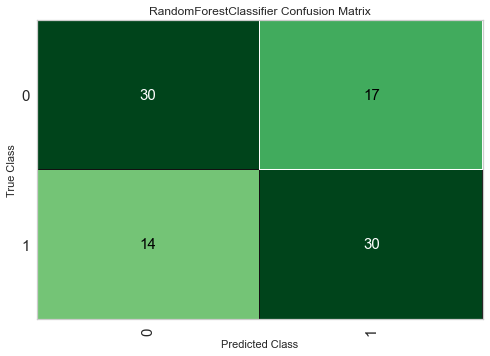

In [44]:
plot_model(tuned_rf_n, plot = 'confusion_matrix')

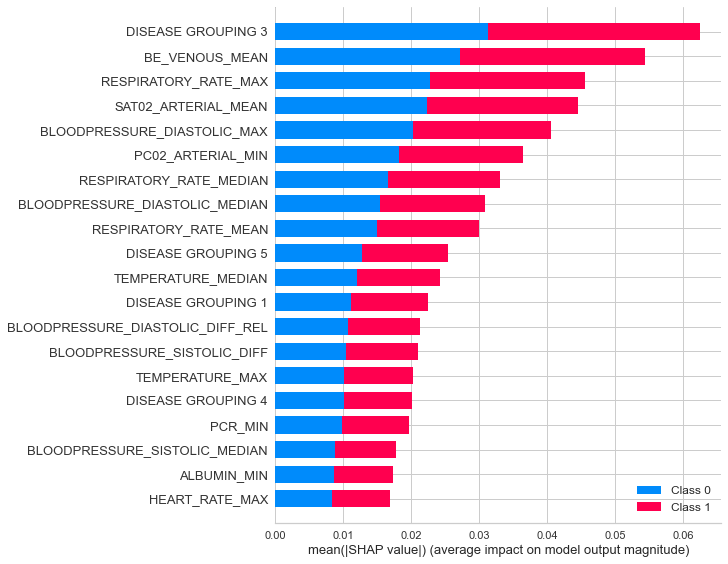

In [45]:
interpret_model(tuned_rf_n)

In [46]:
interpret_model(tuned_rf_n, plot='reason', observation = 10)

In [47]:
predict_model(tuned_rf_n);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Random Forest Classifier,0.6593,0.7495,0.6818,0.6383,0.6593,0.3194


In [48]:
final_rf_n = finalize_model(tuned_rf_n)

In [49]:
unseen_predictions_rf_n = predict_model(final_rf_n, data=unseen_data_pycaret_normalized)

In [50]:
unseen_predictions_rf_n

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_NEW,Label,Score
0,327,1,80,1,-0.028561,-0.013941,-0.026996,-0.011645,0.214379,-0.018173,...,-0.045808,-0.045497,-0.042063,-0.048013,-0.027002,0-2,0,1,0,0.4961
1,328,0,10,0,-0.047461,-0.023166,-0.044861,-0.019351,-0.052195,-0.030199,...,-0.076122,-0.075605,-0.027964,-0.079785,-0.044871,0-2,0,0,0,0.2706
2,330,1,90,1,-0.042510,-0.020749,-0.040181,-0.017332,-0.046750,-0.027049,...,-0.068181,-0.067718,-0.062606,-0.071462,-0.040190,0-2,0,0,1,0.5172
3,331,1,70,0,0.279680,-0.016537,0.295889,-0.013814,-0.037261,0.439547,...,0.010545,0.017233,-0.018300,0.065703,-0.023907,0-2,0,0,1,0.5956
4,332,1,80,0,-0.029644,-0.014469,0.258888,-0.012086,0.222509,-0.018862,...,-0.047546,-0.047223,-0.043658,-0.049834,-0.028026,0-2,0,0,1,0.7248
5,333,1,90,0,-0.030592,-0.014932,-0.028916,-0.012473,0.229626,-0.019466,...,-0.049066,-0.048733,-0.045054,-0.051428,-0.028923,0-2,0,0,1,0.8917
6,334,0,40,1,-0.045361,-0.022141,-0.042876,-0.018494,-0.049886,-0.028863,...,-0.072754,-0.072260,-0.066805,-0.076256,-0.042886,0-2,0,0,0,0.2433
7,335,1,80,1,-0.051612,-0.025192,-0.048785,-0.021043,-0.056761,-0.032841,...,-0.082781,-0.082218,-0.076012,-0.086765,-0.048796,0-2,0,0,0,0.3600
8,336,0,10,1,-0.032433,-0.015831,-0.030657,-0.013224,-0.035669,-0.020637,...,-0.052019,-0.051666,-0.047766,-0.054523,-0.030664,0-2,0,0,1,0.7333
9,337,0,20,0,-0.061850,-0.030189,-0.058462,-0.025217,-0.068020,-0.039355,...,-0.035330,-0.058330,-0.036442,-0.045724,-0.028808,0-2,0,1,0,0.1806


In [51]:
unseen_predictions_rf_n.ICU_NEW.value_counts()

0    34
1    19
Name: ICU_NEW, dtype: int64

In [52]:
unseen_predictions_rf_n.Label.value_counts()

0    30
1    23
Name: Label, dtype: int64

In [ ]:
features = ['AGE_ABOVE65','AGE_PERCENTIL', 'GENDER'] + comorb_lst + lab_lst + vitalSigns_lst
X = training_data[features]
y = training_data['ICU_NEW']